In [20]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn import metrics as m
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

%matplotlib inline

GLOB_Y:pd.DataFrame
GLOB_X:pd.DataFrame

In [21]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [22]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [23]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimisation Functions

In [24]:
# GD optimize

def gd_optimize(X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []

    X_trans = np.asarray(X).T
    Y_trans = np.asarray(Y).T

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_trans.shape[0])
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X_trans,Y_trans)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [25]:
# SGD optimize

def sgd_optimize(X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a stochastic gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []

    X_trans = np.asarray(X).T
    Y_trans = np.asarray(Y).T

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_trans.shape[0])
    
    for i in range(num_iterations):
        # Prepare a random subsample of data
        sample_len = random.randint(100,200)
        X_sample = X.sample(sample_len)
        Y_sample = GLOB_Y[X_sample.index]
        X_trans = np.asarray(X_sample).T
        Y_trans = np.asarray(Y_sample).T
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X_trans,Y_trans)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [26]:

# ADAM algorithm
beta_1 = 0.9
beta_2 = 0.999
epsilon = 0.00000001

def corr_val(value, coef, t):
    corr_val_x = value/(1-coef**t)
    return corr_val_x

def v_val_corr(value, t, grad_vec):
    v_val = beta_2*value + (1-beta_2) * np.power( grad_vec, 2)
    return v_val, corr_val(v_val, beta_2, t)

def s_val_corr(value, t, grad_vec):
    s_val = beta_1*value + (1-beta_1) * grad_vec
    return s_val, corr_val(s_val, beta_1, t)

def adam_optimize(X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a an ADAM descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []

    X_trans = np.asarray(X).T
    Y_trans = np.asarray(Y).T

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_trans.shape[0])
    w_v_val, b_v_val = initialize_with_zeros(X_trans.shape[0])
    w_s_val, b_s_val = initialize_with_zeros(X_trans.shape[0])
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X_trans,Y_trans)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w_v_val, w_v_val_corr = v_val_corr(value=w_v_val, t=i+1, grad_vec=dw) # i+1 stands to avoid devision by zero
        b_v_val, b_v_val_corr = v_val_corr(value=b_v_val, t=i+1, grad_vec=db)

        w_s_val, w_s_val_corr = s_val_corr(value=w_s_val, t=i+1, grad_vec=dw) # i+1 stands to avoid devision by zero
        b_s_val, b_s_val_corr = s_val_corr(value=b_s_val, t=i+1, grad_vec=db)

        # update rule
        w -= learning_rate * w_s_val_corr / (np.sqrt(w_v_val_corr) + epsilon)
        b -= learning_rate * b_s_val_corr / (np.sqrt(b_v_val_corr) + epsilon)
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [27]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

### Plot printing functions

In [28]:
def print_plot_pair(costs_sgd, costs_gd, fig_num = 123):

    x_sgd = np.linspace(1, len(costs_sgd), len(costs_sgd))
    x_gd = np.linspace(1, len(costs_gd), len(costs_gd))

    max_loss = max([max(costs_sgd), max(costs_gd)])
    min_loss = min([min(costs_sgd), min(costs_gd)])
    
    plt.figure(fig_num, figsize=(20, 6))

    plt.subplot(121)
    plt.plot(x_gd, costs_gd, )
    plt.ylim([min_loss, max_loss])
    plt.title("GD optimisation")

    plt.subplot(122)
    plt.plot( x_sgd, costs_sgd)
    plt.ylim([min_loss, max_loss])
    plt.title("SGD optimisation")

In [29]:
def print_plot_trio(costs_sgd, costs_gd, costs_adam, fig_num = 123):

    x_sgd = np.linspace(1, len(costs_sgd), len(costs_sgd))
    x_gd = np.linspace(1, len(costs_gd), len(costs_gd))
    x_adam = np.linspace(1, len(costs_adam), len(costs_adam))

    max_loss = max([max(costs_sgd), max(costs_gd), max(costs_adam)])
    min_loss = min([min(costs_sgd), min(costs_gd), min(costs_adam)])
    
    plt.figure(fig_num, figsize=(20, 6))

    plt.subplot(131)
    plt.plot(x_gd, costs_gd, )
    plt.ylim([min_loss, max_loss])
    plt.title("GD optimisation")

    plt.subplot(132)
    plt.plot( x_sgd, costs_sgd)
    plt.ylim([min_loss, max_loss])
    plt.title("SGD optimisation")

    plt.subplot(133)
    plt.plot( x_adam, costs_adam)
    plt.ylim([min_loss, max_loss])
    plt.title("ADAM optimisation")

### Model definition

In [30]:
# model

def model(X_train, Y_train, X_test, Y_test, optim_fun = gd_optimize, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    X_train_trans = np.asarray(X_train).T
    Y_train_trans = np.asarray(Y_train).T
    X_test_trans = np.asarray(X_test).T
    Y_test_trans = np.asarray(Y_test).T

    # Gradient descent
    parameters, grads, costs = optim_fun(X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test_trans)
    Y_prediction_train = predict(w, b, X_train_trans)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train_trans)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test_trans)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

     
    
    return d

Run the following cell to train your model.

In [31]:
# Prepare data
df = pd.read_csv("bioresponse.csv")
GLOB_Y=df['Activity'].values

# choosing numeric features
GLOB_X = df.drop(['Activity'], axis=1, inplace=False)
GLOB_X

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,...,0,0,0,0,0,0,0,0,0,0
1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,...,1,1,1,1,0,1,0,0,1,0
2,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,...,0,0,0,0,0,0,0,0,0,0
4,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,0.308163,...,0,0,0,0,0,0,0,0,0,0
3747,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,0.192527,...,0,0,1,0,1,0,1,0,0,0
3748,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,0.122132,...,0,0,0,0,0,0,0,0,0,0
3749,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,0.372936,...,0,0,0,0,0,0,0,0,0,0


Dataset split

In [32]:
# Create Train and Test samples
X_train, X_test, y_train, y_test = train_test_split(GLOB_X,GLOB_Y,test_size=0.25, random_state=68)

### Optimisation for different learning rates

In [36]:
lern_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

gd_res = []
sgd_res = []
adam_res = []

for i in range(len(lern_rates)):
    print("------------------------------------------------------")
    print("Learning rate: ", lern_rates[i])
    print("Gradient Descent optimised model:")
    gd_res.append(model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = lern_rates[i], print_cost = False))
    print("Stochastic Gradient Descent optimised model:")
    sgd_res.append(model(X_train, y_train, X_test, y_test, optim_fun = sgd_optimize, num_iterations = 2000, learning_rate = lern_rates[i], print_cost = False))
    print("ADAM optimised model:")
    adam_res.append(model(X_train, y_train, X_test, y_test, optim_fun = adam_optimize, num_iterations = 2000, learning_rate = lern_rates[i], print_cost = False))
    print("------------------------------------------------------")

------------------------------------------------------
Learning rate:  0.0001
Gradient Descent optimised model:
train accuracy: 55.52790615001778 %
test accuracy: 55.223880597014926 %
Stochastic Gradient Descent optimised model:
train accuracy: 55.27906150017775 %
test accuracy: 54.90405117270789 %
ADAM optimised model:
train accuracy: 81.76324209029505 %
test accuracy: 76.97228144989339 %
------------------------------------------------------
------------------------------------------------------
Learning rate:  0.0005
Gradient Descent optimised model:
train accuracy: 68.68112335584786 %
test accuracy: 69.5095948827292 %
Stochastic Gradient Descent optimised model:
train accuracy: 68.85886953430501 %
test accuracy: 69.29637526652452 %
ADAM optimised model:
train accuracy: 87.55776750799858 %
test accuracy: 75.69296375266525 %
------------------------------------------------------
------------------------------------------------------
Learning rate:  0.001
Gradient Descent optimised mo

C:\Users\vando\AppData\Local\Temp/ipykernel_30860/2989978550.py:24: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
C:\Users\vando\AppData\Local\Temp/ipykernel_30860/2989978550.py:24: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost


train accuracy: 93.7788837539993 %
test accuracy: 73.02771855010661 %
------------------------------------------------------
------------------------------------------------------
Learning rate:  0.01
Gradient Descent optimised model:
train accuracy: 78.77710629221471 %
test accuracy: 77.50533049040511 %
Stochastic Gradient Descent optimised model:
train accuracy: 78.91930323498045 %
test accuracy: 77.29211087420043 %
ADAM optimised model:
train accuracy: 94.27657305367934 %
test accuracy: 73.02771855010661 %
------------------------------------------------------
------------------------------------------------------
Learning rate:  0.05
Gradient Descent optimised model:
train accuracy: 82.18983291859226 %
test accuracy: 77.9317697228145 %
Stochastic Gradient Descent optimised model:
train accuracy: 82.580874511198 %
test accuracy: 77.50533049040511 %
ADAM optimised model:
train accuracy: 95.59189477426236 %
test accuracy: 71.53518123667376 %
-------------------------------------------

### Show plots for ADAM, SGD and GD algoes loss functions

As one can see, the smaller learnin rate value - the more linear loss curve is.
The accuracy for GD and SGD are similar
With ADAM optimisation the accuracy on the training set is much more higher than for GD and SGD.
At the same time the accuracy for test set is better for small learning rate and worse
for big learning rate. All in all the model seems to be overfitted for ADAM optimisation algorithm

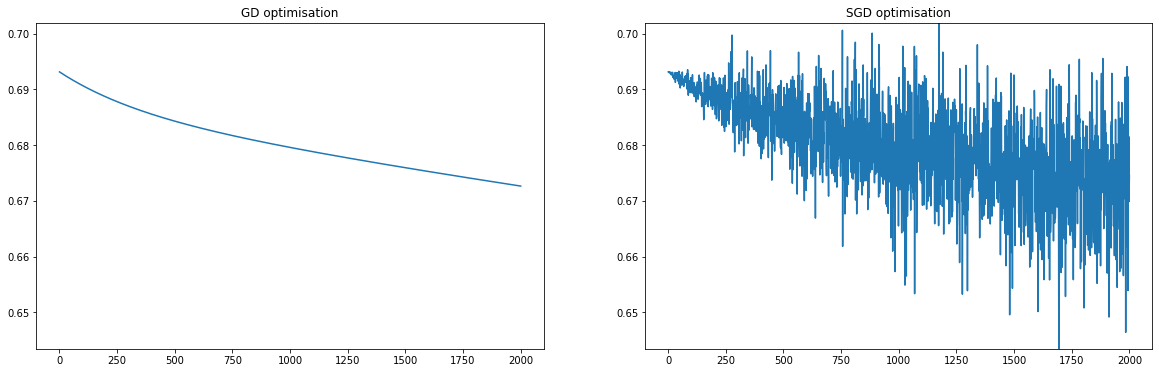

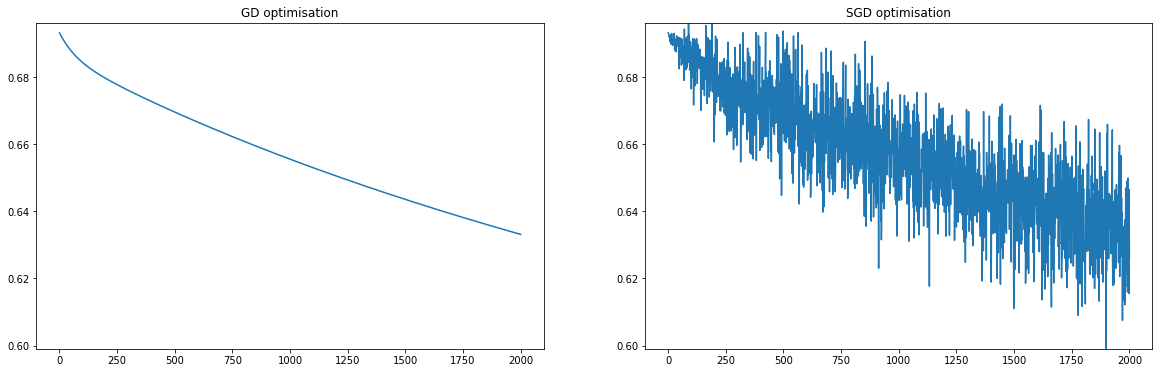

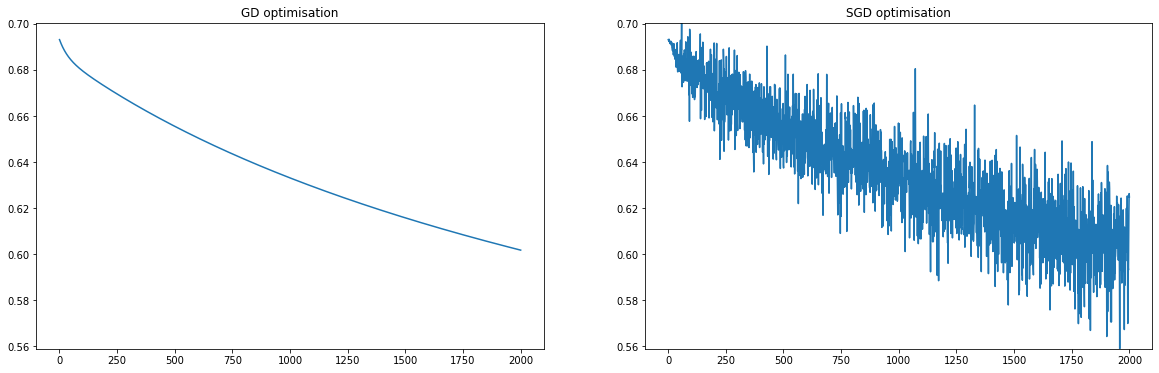

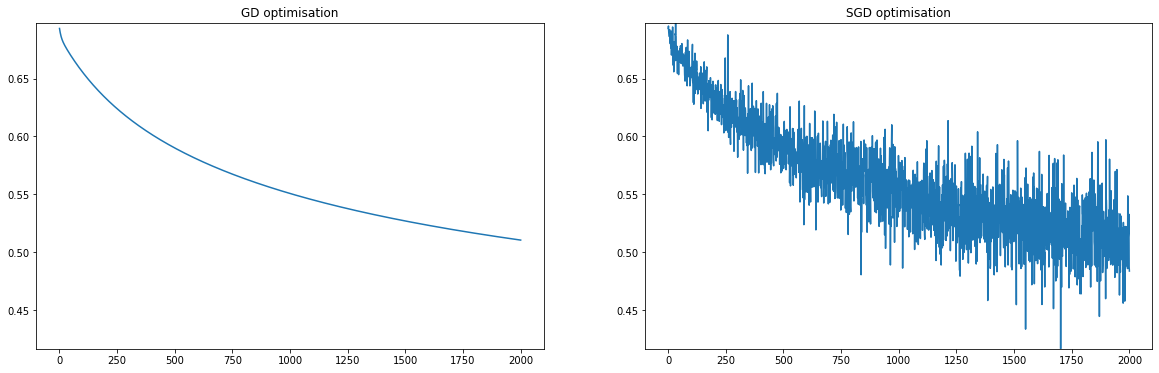

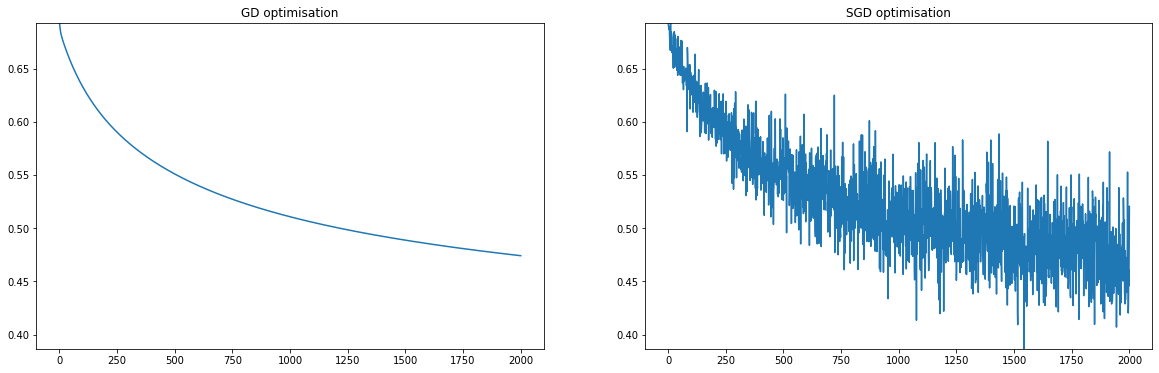

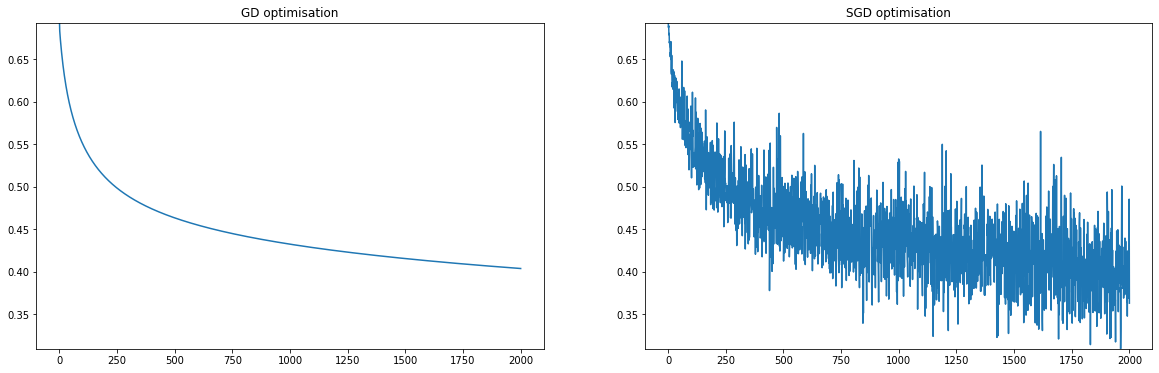

In [37]:
for i in range(len(lern_rates)):
    print_plot_pair(costs_gd = gd_res[i]["costs"], costs_sgd = sgd_res[i]["costs"], fig_num = i)
  

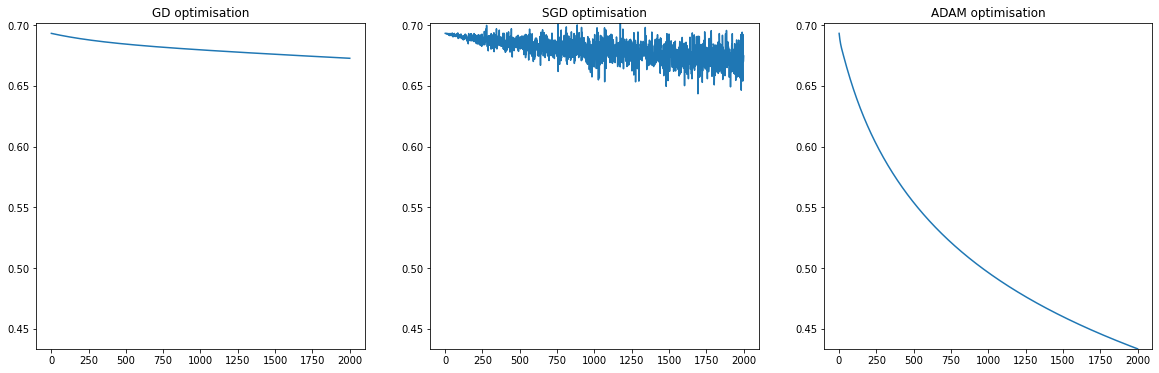

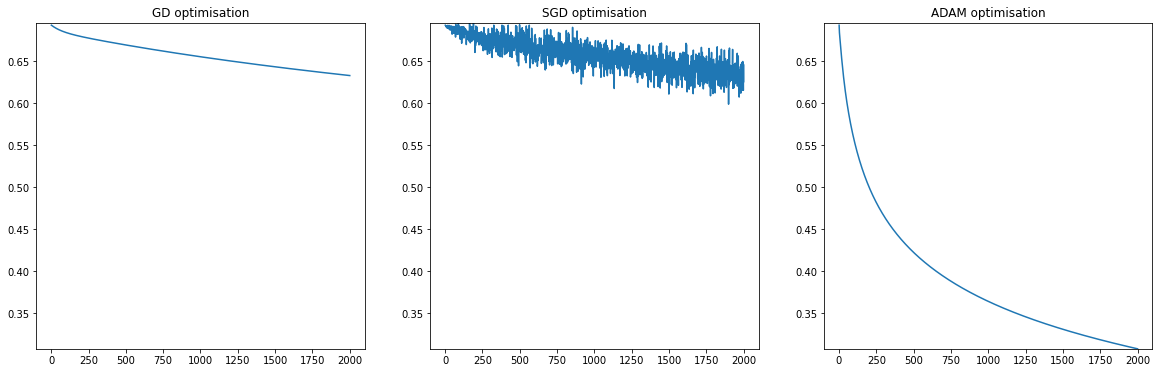

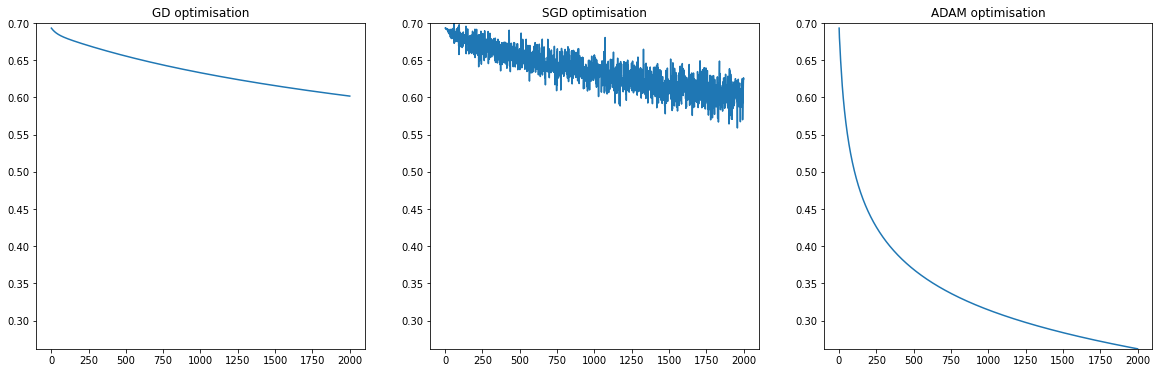

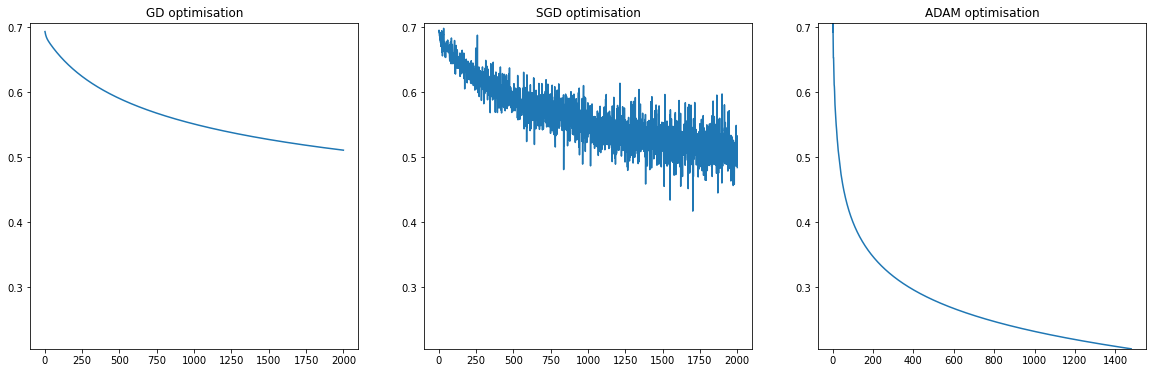

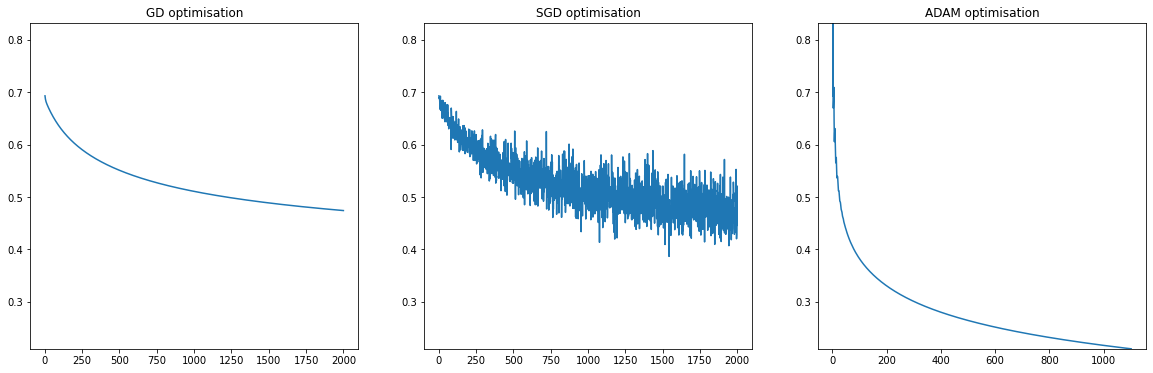

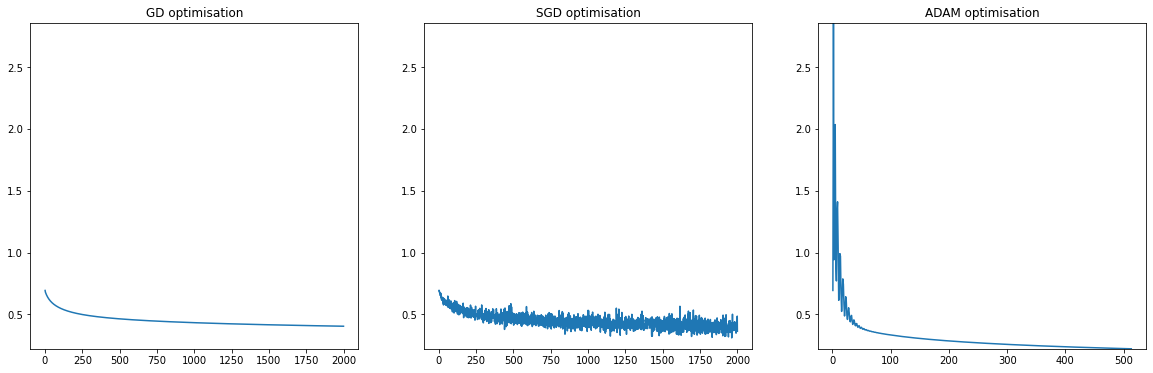

In [40]:
for i in range(len(lern_rates)):
    print_plot_trio(costs_gd = gd_res[i]["costs"], costs_sgd = sgd_res[i]["costs"], costs_adam = adam_res[i]["costs"], fig_num = i)